# Lab 4 - Evidence Accumulation

This lab has two main components designed to go over the process of evidence accumulation.

1. Visualize the drift-diffusion model and see how parameters change evidence accumulation.
2. Introduce an exploratory agent that accumulates sensory evidence , and explore how the parameters of the DDM influence the performance of the agent

## Background

Here we will go over the evidence accumulation process. First we will just explore the dynamics of simple accumulation-to-bound processes. Then we will implement an accumulator process to our chemotaxis valentino agent.

As a reminder, the accumulation-to-bound process models the drift of an evidence process $\theta$ whose rate of change is determined by a drift rate $v$, time $t$, and a diffusion noise constant $\sigma$.

$$\delta\theta = v \delta t + \sigma \delta W$$

Here $W$ is a Wiener noise process. The diffusion of evidence process starts after and onset time $tr$, reflecting sensory delays and it until $\theta \geq \frac{+a}{2}$ or $\theta \leq \frac{-a}{2}$ where $a$ is a threhsold (or boundary height) of evidence. Often $\theta$ starts at 0 (i.e., unbiased), but can start with a degree of bias $z$.

In the simulations we will use for our valentino agents, we will have a 1 dimensional decision. Which means that the process starts at 0 and only continues until it hits the upper boundary $a$ (i.e., stops when $\theta \geq a$) as the agent only need to make one deciison: to change or not to change.

## Section 0 - Setup

First let's set things up for the two parts of the lab.

### Install ADMCode and explorationlib libraries

Install the code for running the DDM simulations (ADMCode) and the evidence accumulation agents (explorelib)

In [ ]:
# Install explorationlib & gym-maze
!pip install --upgrade git+https://github.com/coaxlab/explorationlib.git
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs

  Cloning https://github.com/coaxlab/explorationlib.git to /tmp/pip-req-build-zcyd8rpy
  Running command git clone --filter=blob:none --quiet https://github.com/coaxlab/explorationlib.git /tmp/pip-req-build-zcyd8rpy
  Resolved https://github.com/coaxlab/explorationlib.git to commit 1370823ba06ddf3a3b14929e3de0cb4d16b7ce49
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=42722 sha256=b5426a29149f735caf06c253c71eefe23b7c7d2929a0c7e93da88c4b57e73e20
  Stored in directory: /tmp/pip-ephem-wheel-cache-tsqmlru6/wheels/6b/01/d7/fc7db2f6725fb2c9f5a0d6810f004013ddafba46f4db1ad43b
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-16cpzbxc
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-16cpzbxc
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc

### Import Modules

Here we will bring in all the modules and libraries that we will need for this lab.

In [ ]:
# ADM modules
from __future__ import division
from ADMCode import visualize as vis
from ADMCode import ddm, sdt

import numpy as np
import pandas as pd

from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from copy import deepcopy

# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionDiscrete
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientDiffusionDiscrete
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import TruncatedLevyDiscrete

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import create_grid_scent_patches

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death

/usr/local/lib/python3.10/dist-packages/explorationlib/run.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Notebook Config

Now let's do some tweaks to get the notebooks to render things nicely.

In [ ]:
# Pretty plots
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section 1 - Simulating the Drift-Diffusion Model

Here, we will visualize the DDM in action and see how changes in its parameters affect the accuracy and reaction times of the decision process.

First thing first, let's take a look at the code. It can be found in the Colab virtual machine here: /usr/local/lib/python3.7/dist-packages/ADMCode/ddm.py

### DDM Parameters

Let's start with a simple set of simulations using the parameters below. The parameters get passed to the DDM agent as a numpy array.

In [ ]:
a = .15 # boundary height
v = .1 # strong drift-rate
tr = .25 # nondecision time (in seconds)
z = .5 # starting point ([0,1], fraction of a)

dt = .001 # time stepsize
si = .1 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence stepsize (up/down)
deadline = 1.75 # max decision time (in sec)
ntrials = 1000 # number of trials to simulate

parameters = np.array([a, tr, v, z, si, dx, dt])

### Generating Data

The **ddm.sim_ddm_trials** function runs a set of trials (default 500 trials) of a DDM with the parameters specified in your parameters array. Let's try it.

In [ ]:
df, traces = ddm.sim_ddm_trials(parameters, ntrials, deadline)
df.head()

,trial,rt,choice
0,1,0.562,1.0
1,2,1.278,1.0
2,3,0.452,1.0
3,4,0.406,1.0
4,5,1.072,0.0


This produced an output object called **traces** that has not only the choice and reactiontime on each trial, but also the information diffusion traces for each run of the DDM.

One important thing to note is that in these simulations the upper bound represents the "correct" choice, while the lower bound represents "errors". So this is what is known as an accuracy coding for the DDM.

### Analyze simulated behavior

In [ ]:
accuracy = df.choice.mean()
corRT = df[df.choice==1].rt.mean()
errRT = df[df.choice==0].rt.mean()

print("RT (cor) = {:.0f} ms".format(corRT/dt))
print("RT (err) = {:.0f} ms".format(errRT/dt))
print("Accuracy = {:.0f}%".format(accuracy*100))

RT (cor) = 701 ms
RT (err) = 692 ms
Accuracy = 84%


As we can see, the DDM is biased towards the upper boundary. What parameter defines this bias in the model that we set up? **v**

### Plot evidence traces

The ADMCode library has a set of custom visualization tools that allow us to see the DDM in action. Let's take a look at one of them.

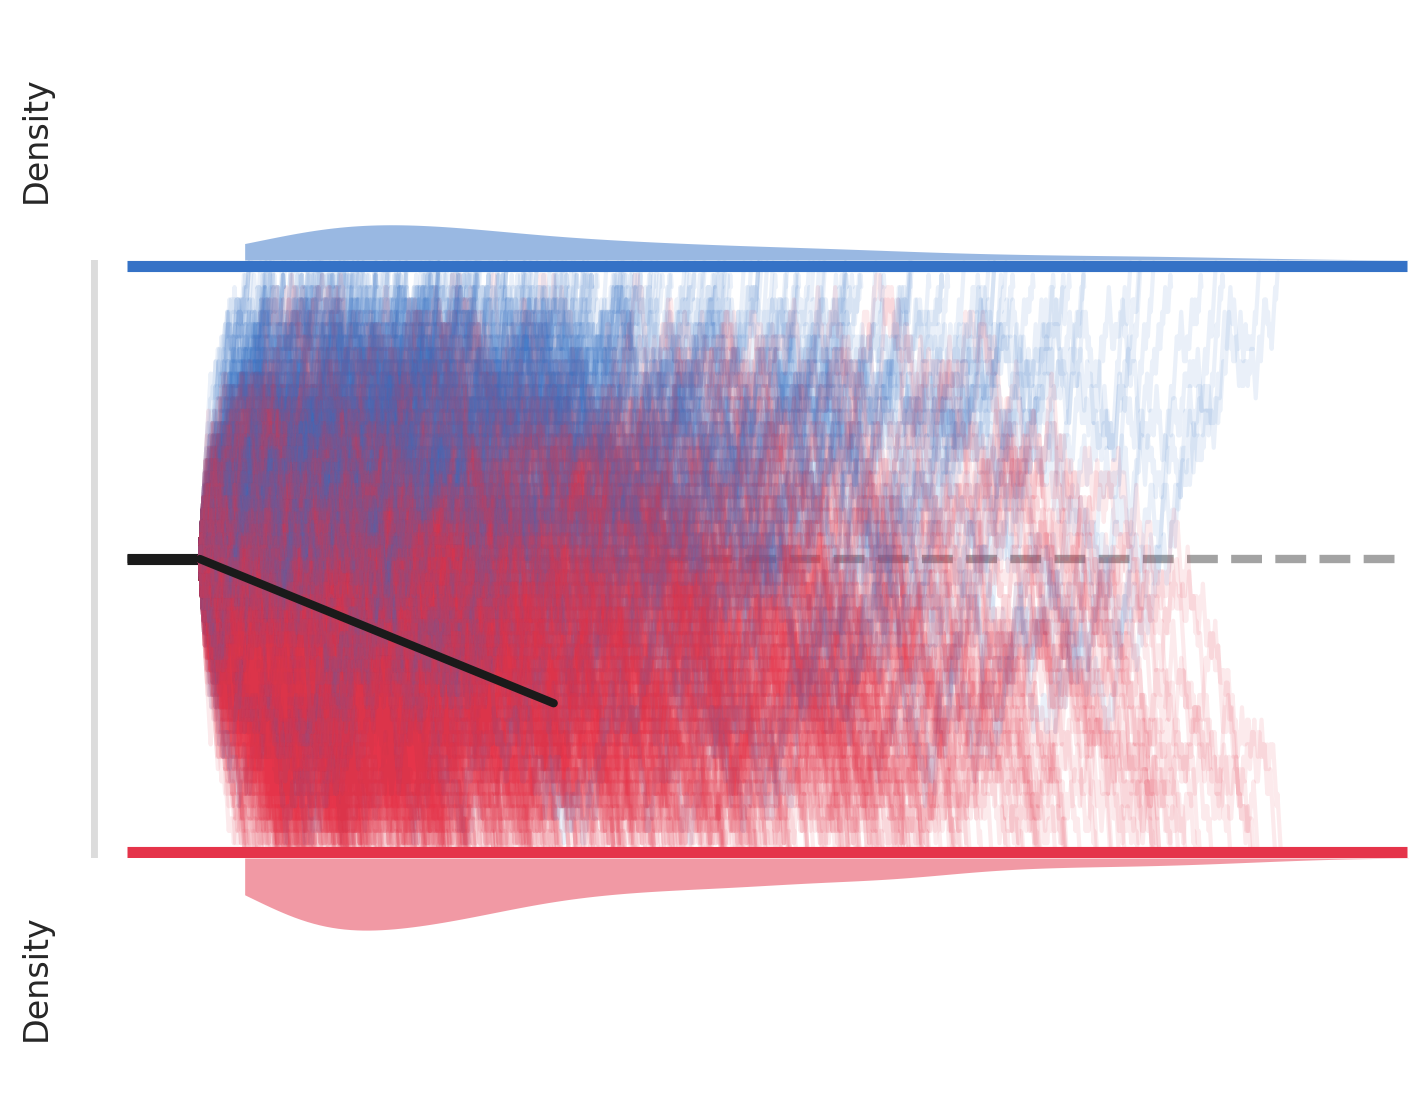

In [ ]:
ax = vis.plot_ddm_sims(df, parameters, traces=traces, plot_v=True)

The plot above shows all fo the traces. Let's see about plotting just the first trial's trace.

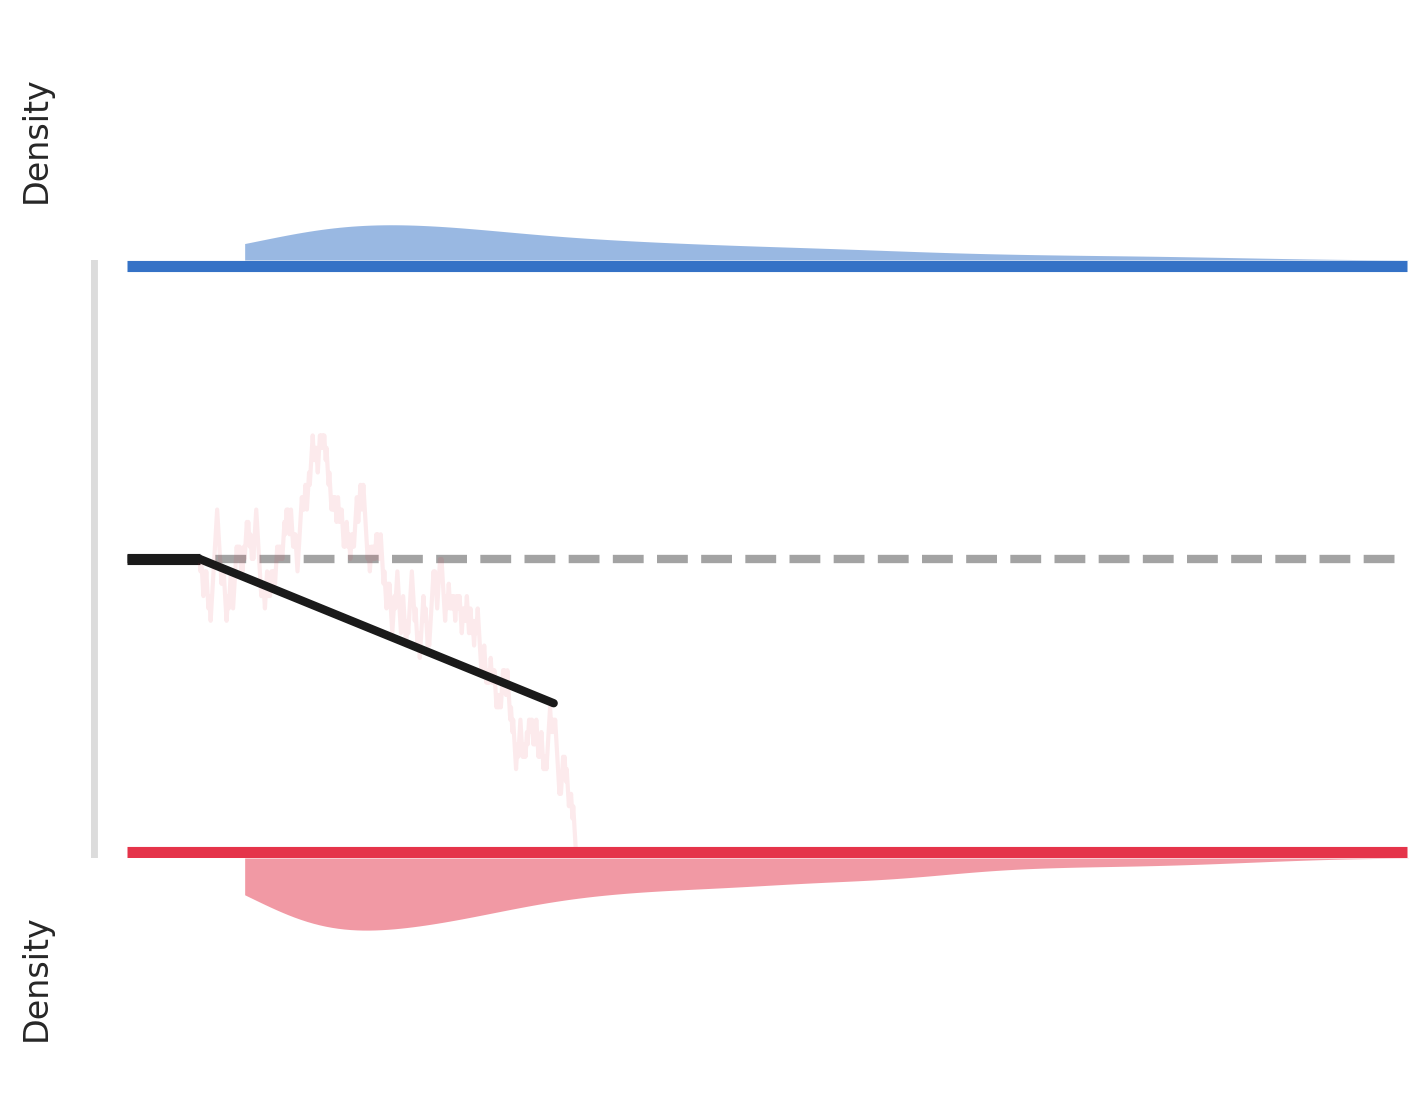

In [ ]:
ax = vis.plot_ddm_sims(df, parameters, traces=traces[:1], plot_v=True)

The example above shows the mean overall drift process trajectory as a solid black line. The single diffusion process plotted is the diffusion process for both trials.

---
### Question 1.1

Re-run the simulations above, but with the following parameters:

a = .25  \\
v = -.05 \
tr = .25 \\
z = .5  \\

dt = .001 \\
si = .1  \\
dx = si * np.sqrt(dt)  \\
deadline = 1.75 \\
ntrials = 1000

_Question_: How did the behavior of the model change? Be specific. What does this tell you about the nature of the parameters that were changed?

__Answer:__

According to the inital values (a = 0.15):

RT (cor) = 742 ms

RT (err) = 739 ms

Accuracy = 34%

However, when the a (boundry height) parameter was increased to 0.25:

RT (cor) = 1022 ms

RT (err) = 1024 ms

Accuracy = 22%

The runtime increased significantly by around 300 ms, and the accuracy decreased significantly as well by around 12%. This shows that higher decision thresholds slow decision-making but may not improve accuracy when evidence is biased.

---
### Question 1.2

Re-run the simulations above, but go back to the baseline parameters, but now change the drift rate to what is below:

a = .15  \\
v = .1 \
tr = .25 \\
z = .5  \\

dt = .001 \\
si = .1  \\
dx = si * np.sqrt(dt)  \\
deadline = 1.75 \\
ntrials = 1000

_Question_: What did changing the boundary height do to the model's behavior? Be specific.

__Answer:__

According to the inital values (v = -0.05):

RT (cor) = 742 ms

RT (err) = 739 ms

Accuracy = 34%

However, when the v (drift rate) parameter was increased to 0.1:

RT (cor) = 701 ms

RT (err) = 692 ms

Accuracy = 84%

Changing the drift rate to 0.1 from -0.05 caused a significant increase in accuracy by around 50% but the runtime stayed around the same values.


## Section 2 - Using Sensory Evidence To Explore


In this section we take on accumulating evidence as a policy for decision making. We'll call this agent our "accumulator" agent ("accum" for short). Our venue is still chemotaxis, but now our sensors are noisy. The presence of this uncertainty makes decisions--of the kind common to decision theory--a necessity.

The agents we will be using are the same as used in the Chemotaxis lab (Lab 3). Look back there to see the structure of the gradient search. But here we will explore something in more detail that we skipped over in that lab: evidence accumulation.


## Accumulation of chemosignals

Because an accumulator is present, our chemo agent sequentially tries to estimate the scent gradient by sampling the new current location, until the threshold is met.

Chemo-accumulators have what we can think of as two cognitive or behavioral steps:

1. Use an accumulator to (stabely) estimate the chemo gradient
2. Use the gradient to make turning decisions

More specifically, the agent alternates between sensory measurement and movement. When the agent senses its environment, it determines the shape of the scent gradient at its current location. Based on the gradient, the agent might change its direction of travel.  Then agent then travels a certain distance in a straight line. When the scent gradient is positive, meaning you are going "up" the gradient, the probability of turning is set to _p pos_. When the gradient is negative, the turning probability is set to _p neg_. (See code for an example). If the agents turns, the direction is uniform random. The length of travel before the next sensory measurement is sampled from an exponential distribution just like the _DiffusionDiscrete_


The decision to be made is this: is the gradient increasing or decreasing?

For this, we'll add a  kind of gradient search that uses a DDM-style accumulator to make decisions about the direction of the gradient. Each time step of the simulation can be spent thinking (accumulating evidence at the current location) _or_ acting (jumping to the next location). We assume an agent can't think and act at the same time.

Food for thought: Is it better to spend time rationally accumulating evidence, or is it better to just act?

In this section, to really understand the thinking-action trade-off, we'll be looking at the results from the following perspective:
- average reward
- best reward
- total distance travelled
- number of deaths*

*Any experimental trial which does not lead to finding at least a single target (aka reward) means the exploring agent dies. It's a harsh noisy world we live in, after all.

We'll look at a noisy, somewhat target-filled, domain and explore how speed, accuracy, and death rate are influenced by the parameters of our drift-diffusion model.

The code for this agent can be found here /usr/local/lib/python3.7/dist-packages/explorationlib/agent.py. The _AccumulatorGradientGrid_ agent code can be found on line 1090 of the _agents.py_ library.

### Example: Influence of drift rate on performance

Based on what you have been told so far, how would you expect increases in the _drift rate_ to affect average rewards, best rewards, and deaths in an open field task, with sparse targets and noisy scents?

Here, drift rate can be conceptualized as the fidelity of sensory signal, like a sort of signal-to-noise ratio.

### Making things a bit more difficult

Because we are making "smarter" agents we can increase the difficulty of our search problem. We are going to start allowing for signal dropout. What we mean by that is we will make some information disappear... poof! Imagine that scent molecules are decomposing and they just drop out of our substrate randomly.

We can control the probability of a scent molecule being detected at any point in space with the *p_scent* parameter.

Let's see how this works. First, we can recreate our scent distributions from Lab 2. But we set *p_scent* to 0.1, which means that there is a 10% probabilty of detecting the scent at each point of the grid (or a 90% signal drop out rate).

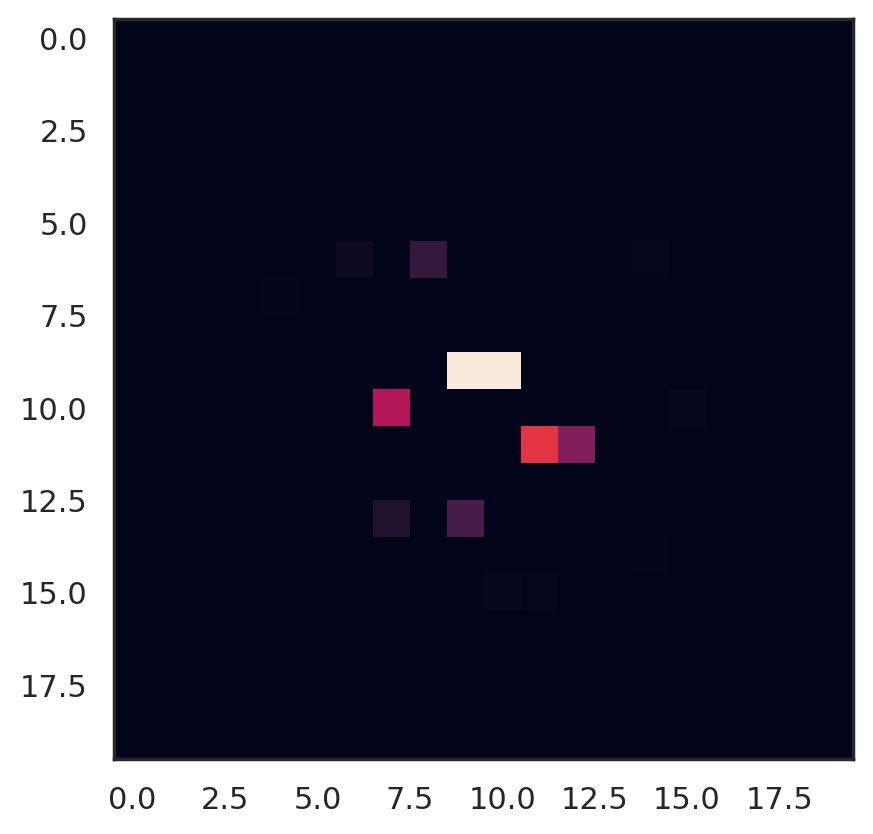

In [ ]:
target_boundary = (10, 10)
amplitude = 1000
p_scent = 0.1
noise_sigma = 2.0

coord, scent = create_grid_scent_patches(target_boundary, p=p_scent, amplitude=amplitude, sigma=noise_sigma)

plt.imshow(scent, interpolation=None)

As you can see, it is pretty noisy.

So like before, let's average across 100 targets to see what the modal resolvable scent looks like (on average)

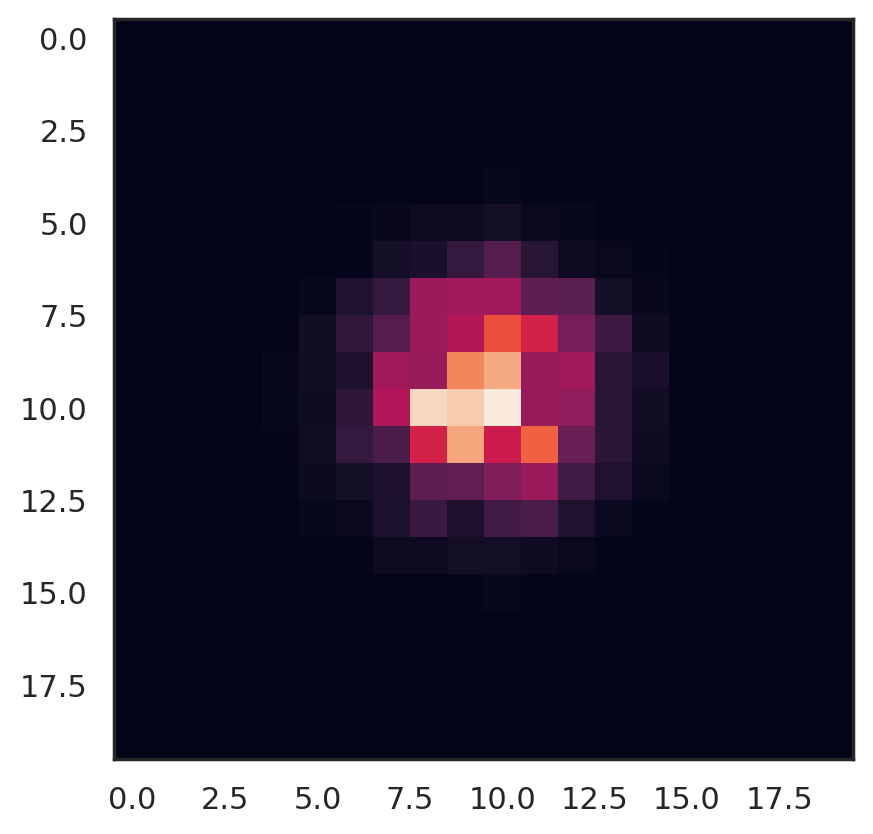

In [ ]:
amplitude = 1
p_scent = 0.1
num_samples = 100

scents = []
for _ in range(num_samples):
    coord, scent = create_grid_scent_patches(target_boundary, p=p_scent, amplitude=1, sigma=2)
    scents.append(deepcopy(scent))

scent = np.sum(scents, axis=0)

plt.imshow(scent, interpolation=None)

### Create environment

The name of the env for this section is the _ScentGrid_. It basically parses up the continuous space into a grid of steps.

Let's add some targets and scents to it. Now we are doing to include the drop out of the scent, setting *p_scent* to 0.5 (50% drop out)

In [ ]:
# Shared exp parameters
num_steps = 200
max_steps = 10
seed_value = 5838

min_length = 1
step_size = 0.1

noise_sigma = 2
detection_radius = 1
num_targets = 250
target_boundary = (100, 100)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
amplitude = 1000
p_scent = 0.95
noise_sigma = 1.0
coord, scent = create_grid_scent_patches(target_boundary, p=p_scent, amplitude=amplitude, sigma=noise_sigma)
scents = [scent for _ in range(len(targets))]
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

First, let's see how our environment looks. Each point represents a food target.

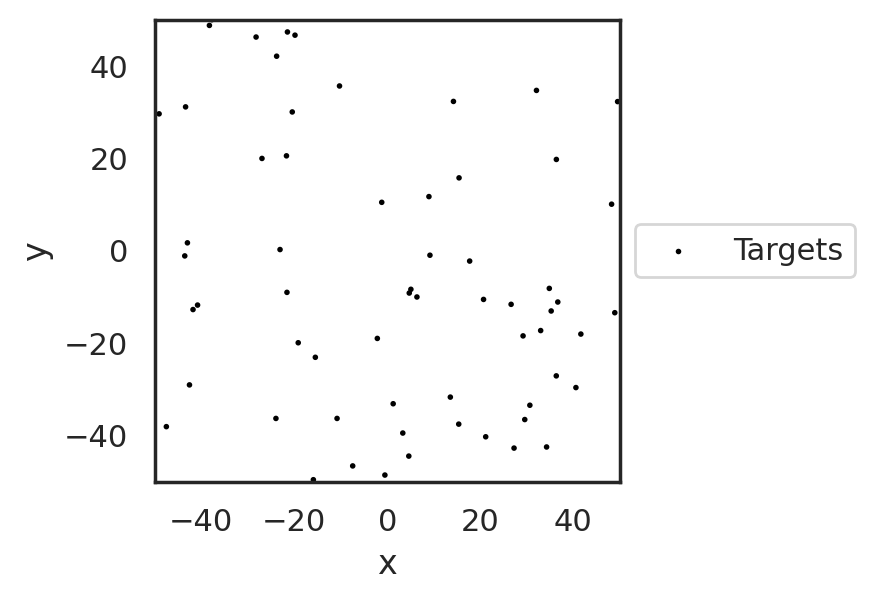

In [ ]:
plot_boundary = (50, 50)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

So we now have another dimension with which to make our stimulus noisy. Just to make things harder.


### Drift rates

Now let us turn to setting up our agents. We'll play with agents with various rates of evidence accumulation.

Using the _env_ defined above explore the following drift rates:

In [ ]:
# Our parameters
thresholds = [2.0, 2.5, 3.0, 3.5, 4.0]

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = drift_rates # list(range(5))

---
###Question 2.1

In the context of this gradient decision that our wandering agent does, what should _increasing_ the drift rate do to the agent's behavior?

__Answer:__

Increasing the drift rate should decrease the run distance.

### Run


Next we will run 100 experiments for each drift rate.

_Note:_ This will take a few minutes to run.

In [ ]:
# Exp params
threshold = 3.0
accumulate_sigma = 1.0

num_experiments = 100

# Run
results = []
for i, drift_rate in zip(names, drift_rates):
    accum = AccumulatorGradientGrid(
        min_length=min_length,
        max_steps=max_steps,
        drift_rate=drift_rate,
        threshold=threshold,
        accumulate_sigma=accumulate_sigma
    )
    accum.seed(seed_value)
    # !
    exp = experiment(
        f"accum_{i}",
        accum,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=True,
        seed=seed_value
    )
    results.append(exp)

accum_0:   0%|          | 0/100 [00:00<?, ?it/s]

accum_0:   0%|          | 0/100 [00:00<?, ?it/s]

accum_1:   0%|          | 0/100 [00:00<?, ?it/s]

accum_1:   0%|          | 0/100 [00:00<?, ?it/s]

accum_1:   0%|          | 0/100 [00:00<?, ?it/s]

### Plot an example

In order to understand how our different agents, with different drift rates, do we can start with a qualitative analysis. Here we will plot a single trial for each agent.

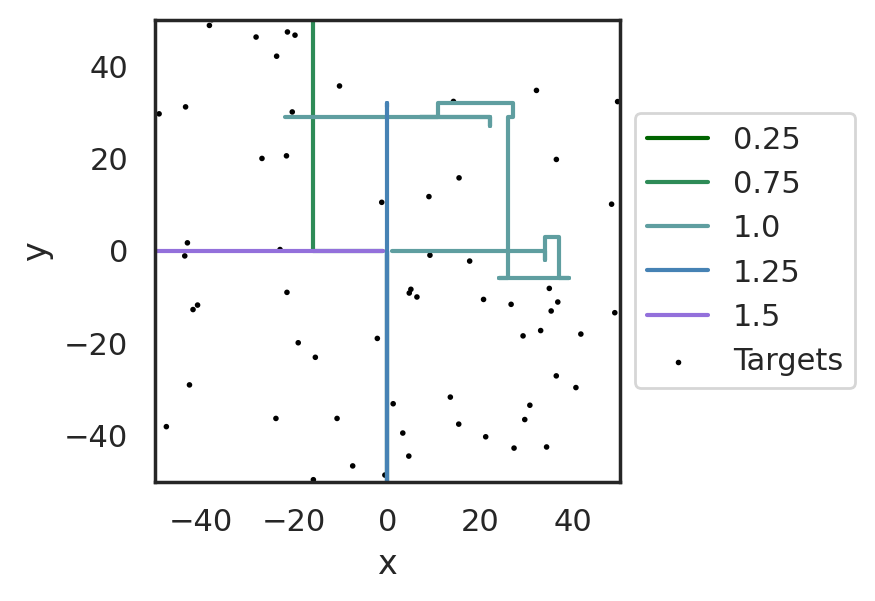

In [ ]:
plot_boundary = (50, 50)
num_experiment = 40
ax = None
for i, result, color in zip(names, results, colors):
    ax = plot_position2d(
        select_exp(result, num_experiment),
        boundary=plot_boundary,
        label=i,
        color=color,
        alpha=1,
        ax=ax,
    )
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

### Plot several metrics

Next let us look at differenet metrics of behavior instead, to get a better idea of what changing the drift rate does.

The metrics we will look at are: distance, death, best reward, average reward.


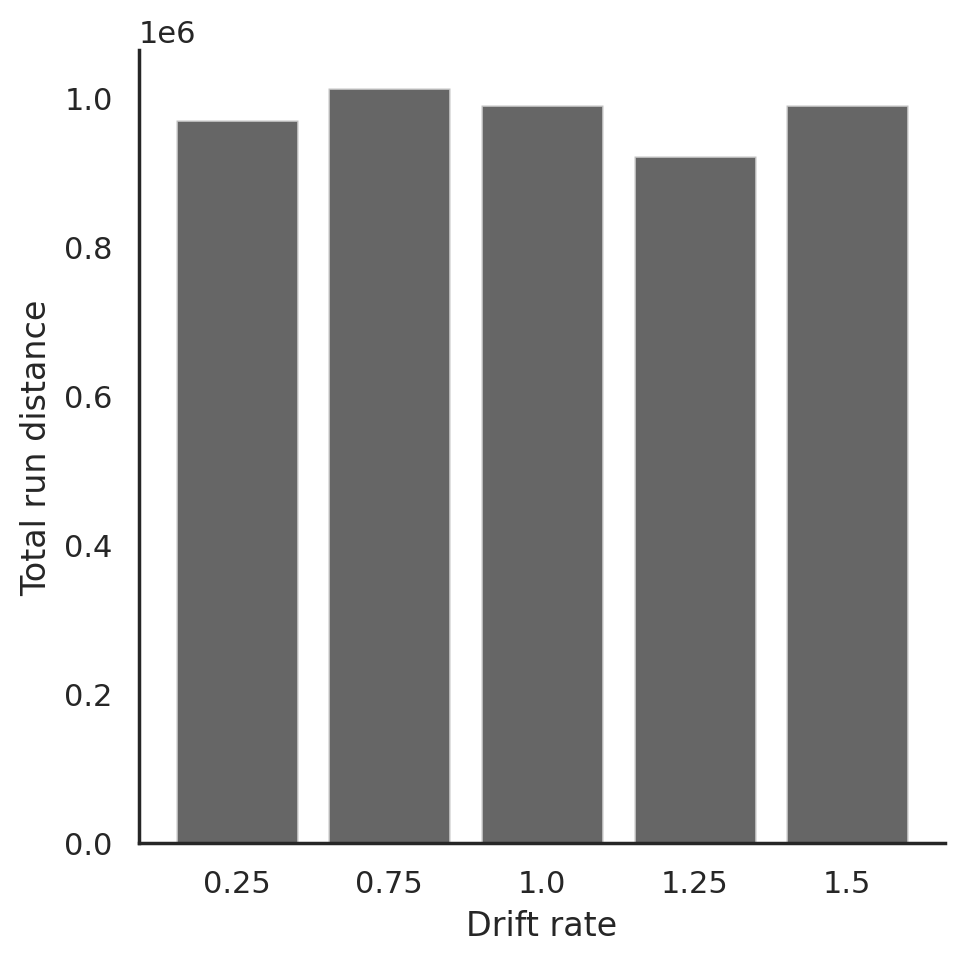

In [ ]:
# Score
scores = []
for result in results:
    l = 0.0
    for r in result:
        l += np.sum(r["agent_num_step"])
    scores.append(l)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total run distance")
plt.xlabel("Drift rate")
plt.tight_layout()
sns.despine()

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

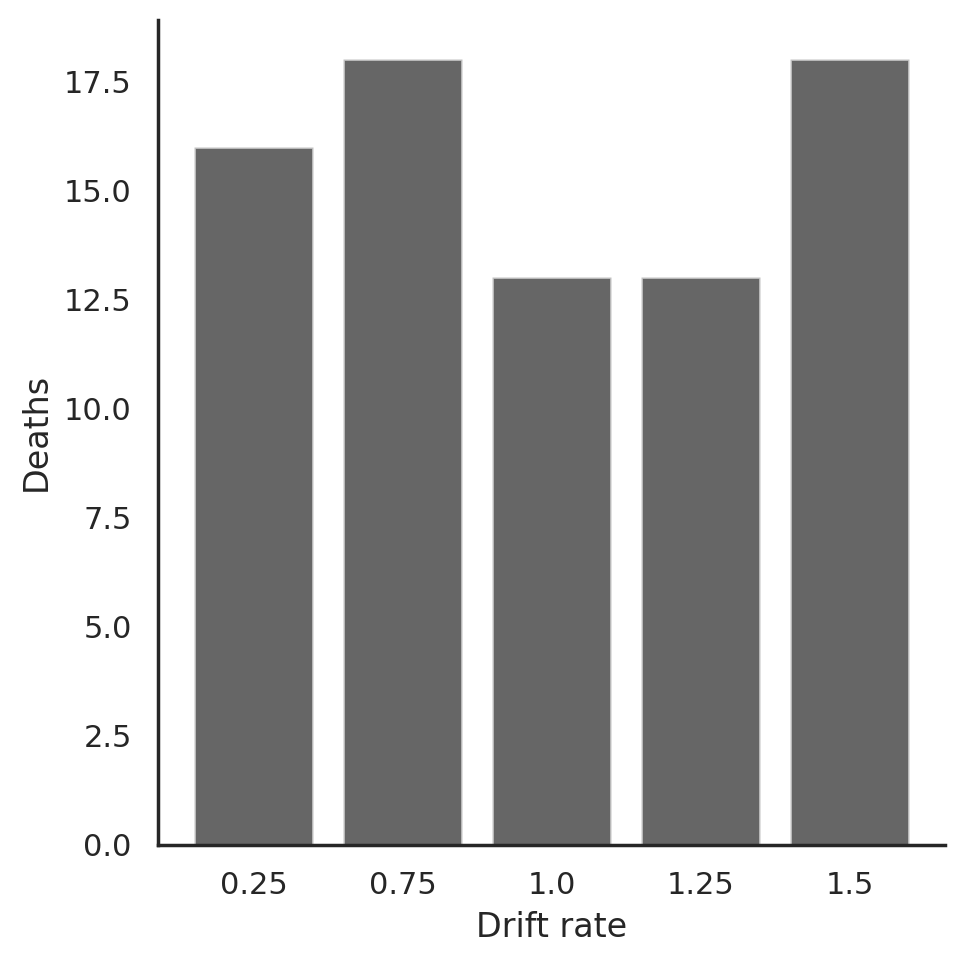

In [ ]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Drift rate")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

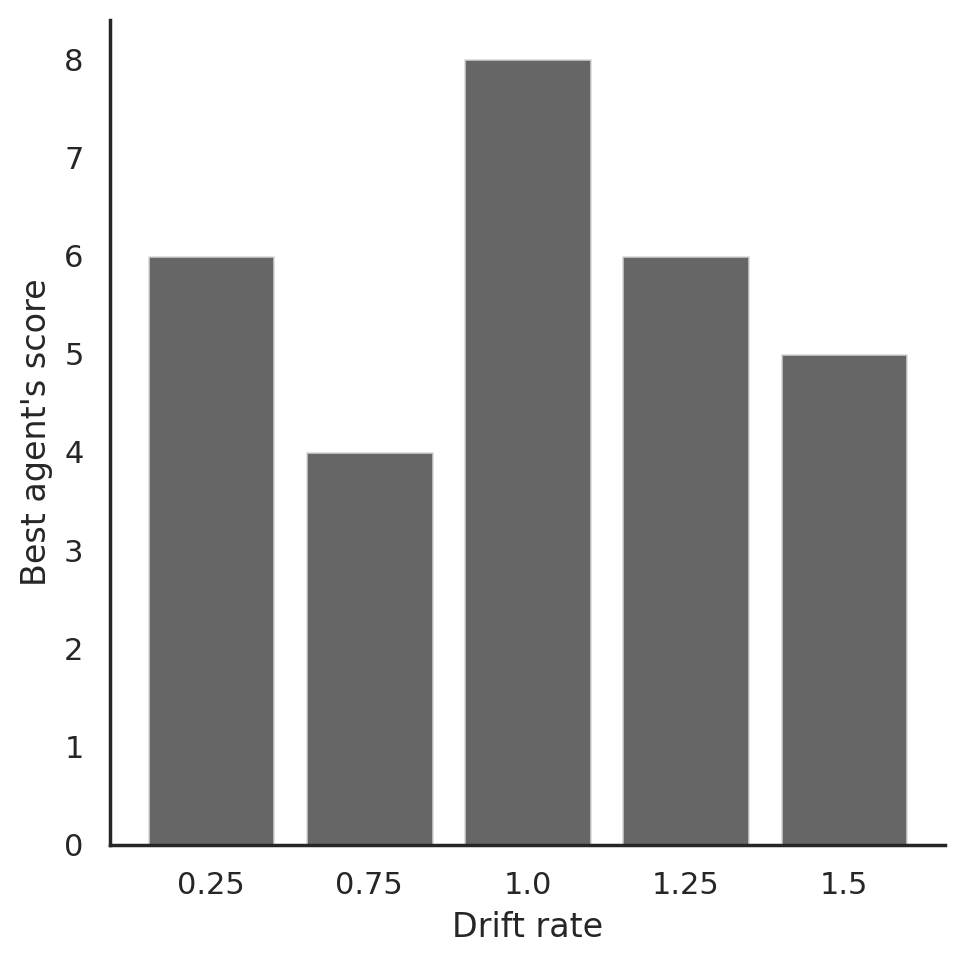

In [ ]:
# Max Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best agent's score")
plt.xlabel("Drift rate")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

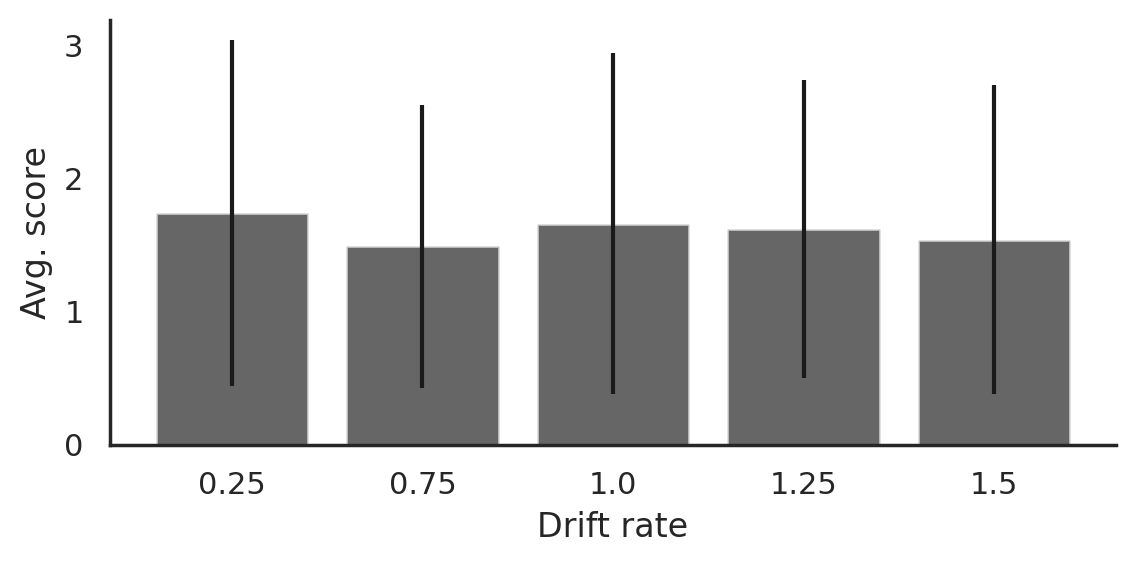

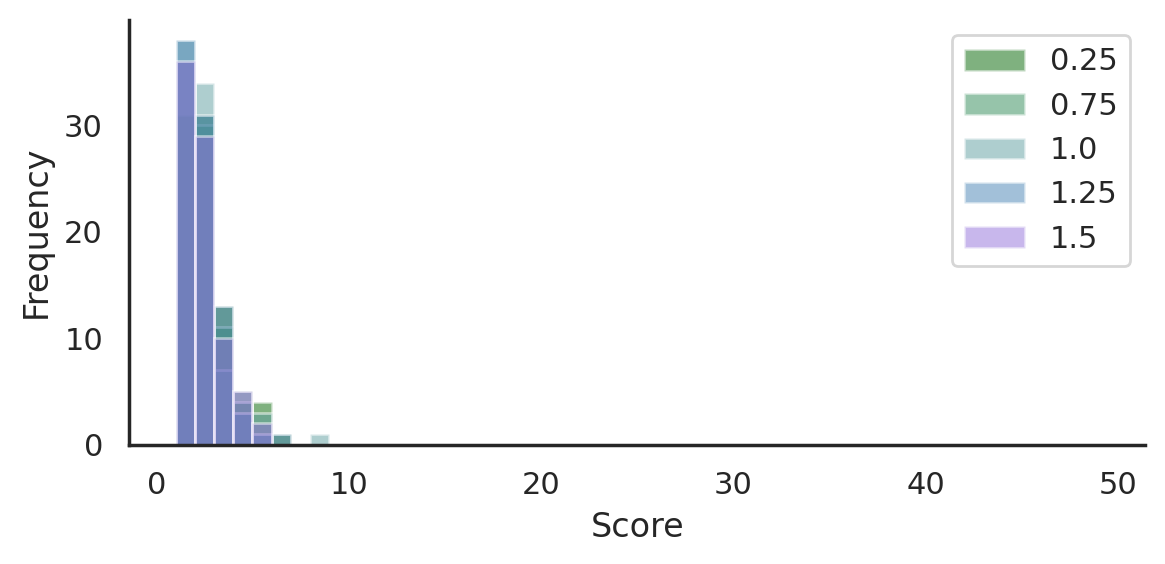

In [ ]:
# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(6, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Drift rate")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.ylabel("Frequency")
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

---
### Question 2.2

Describe how increasing the drift rate changes the overall performance of the agent along the dimensions we just plotted. What does this tell you about how the drift rate is changing behavior?

__Answer:__

Along the dimensions we plotted, the drift rate did not really change the overall performance (distance, death, best reward, average reward). Increasing the drift rate did not really increase the number of tumble decisions made.

---
### Question 2.3

Re-run the simulations above, instead keeping the drift rate at 1.0, and varying the _threshold_ parameter (aka- boundary height) as:

thresholds = [2.0, 2.5, 3.0, 3.5, 4.0]


_Question_: How does changing the threshold impact performance of the agent and how does this differ from the drift rate?

__Answer:__

Increasing the threshold while keeping the drift rate fixed at 1.0 resulted in longer reaction times because the model needs more evidence to rach the decision boundary. The accuracy also increased as well, since more evidence allows for a more informed and less hasty decision. On the other hand, the drift rate influences the speed and direction of the evidence.


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> *Write Name(s) here*